# Assignment 1: NARMA10 task
## TDNN

In [12]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
import keras_tuner as kt

### Load the dataset

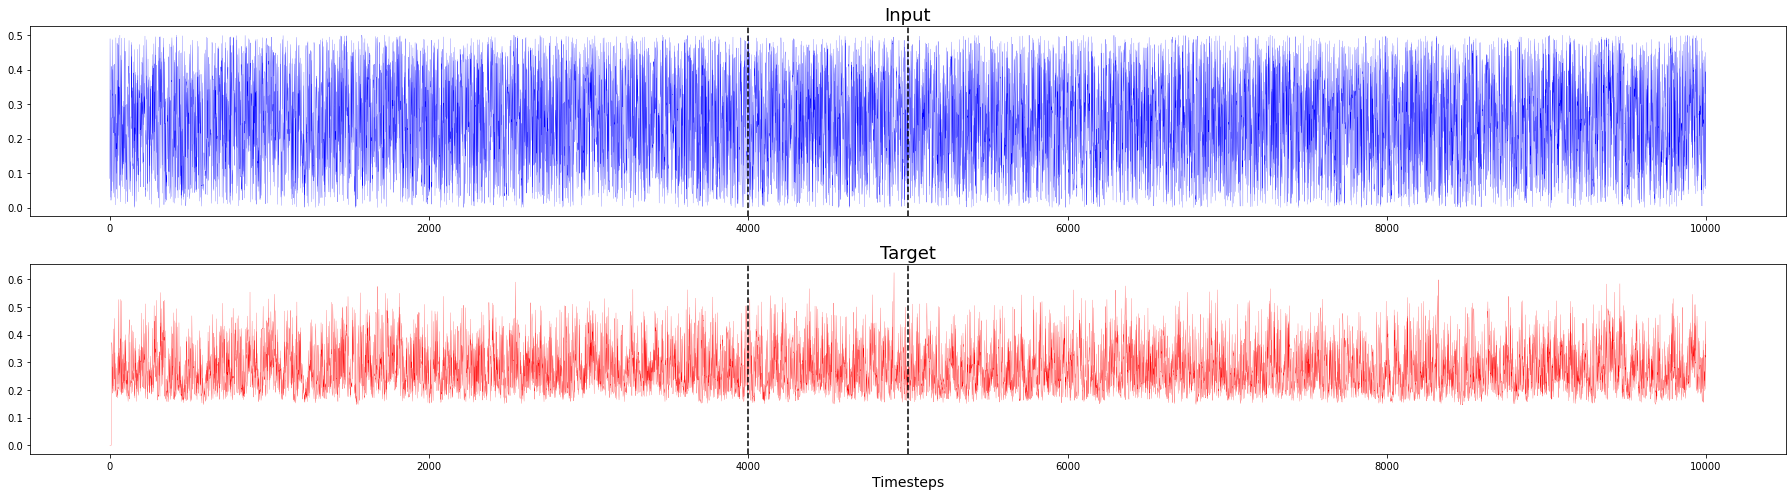

In [26]:
#load the data
x, y = np.loadtxt("NARMA10.csv", delimiter=",")


#split the dataset into training, validation and test
x_train = x[:4000]
x_valid = x[4000:5000] #validation
x_test = x[5000:]

y_train = y[:4000]
y_valid = y[4000:5000]
y_test = y[5000:]

#plot the data
t=np.arange(start=0,stop=len(x), step=1)
plt.figure(figsize = (25,7))
ax1 = plt.subplot(211)
plt.title('Input', fontsize=18)
ax1.plot(t,x, color = 'b', linewidth= 0.2)
ax1.axvline(x = 4000, color = 'black', linestyle= '--')
ax1.axvline(x = 5000, color = 'black', linestyle= '--')

ax2 = plt.subplot(212, sharex = ax1)
plt.title('Target', fontsize=18)
ax2.plot(t,y, color = 'r', linewidth = 0.2)
ax2.axvline(x = 4000, color = 'black', linestyle= '--')
ax2.axvline(x = 5000, color = 'black', linestyle= '--')
plt.xlabel('Timesteps', fontsize=14)
plt.tight_layout()

### Create the model
Actually we create the "hypermodel", defining the hyperparameter search space as well as the architecture of the model.

In [14]:

def create_model(hp):
    model = Sequential()
    input_shape = (1, 10) #lo tengo fisso?

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 10-100
    hidden_units = hp.Int('units',  min_value=10, max_value=300, step=10)
    model.add(Dense(units=hidden_units,input_shape=input_shape, activation='tanh'))
    model.add(Dense(units=1, activation='tanh'))


    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),metrics=['mean_squared_error'])
    return model

Instantiate hyperparameter tuner

In [15]:
# magari usare RandomSearch? 
tuner = kt.Hyperband(create_model,
                     objective='val_mean_squared_error',
                     max_epochs=10,
                     factor=3,
                     directory='tuner',
                     project_name='tuner_kt',
                     overwrite=True
                     )


Create a callback to stop training early after reaching a certain value for the validation loss.

In [16]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [17]:
# Prepare the input X and target Y in order to implement the tdnn
def get_XY(x, y, window):
    # Remove the first "window" elements from y array
    Y = y[window:]
    # X will be an array containing "len(Y)" arrays created using the sliding window
    X = []
    rows_x = len(Y)
    j = 0
    for i in range(rows_x):
        X = np.append(X,x[j:j+window])
        j = j + 1

    #reshape X so it can be fed to the Dense layer
    X =  np.reshape(X, (rows_x, 1, window)) 
    return X, Y 

 
window = 10

#prepare the data
trainX, trainY = get_XY(x_train, y_train, window)
validX, validY = get_XY(x_valid, y_valid, window)
testX, testY = get_XY(x_test, y_test, window)

#check shape
print(trainX.shape,trainY.shape)

(3990, 1, 10) (3990,)


In [18]:
tuner.search(trainX, trainY, epochs=50, validation_data = (validX, validY), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


Trial 30 Complete [00h 00m 03s]
val_mean_squared_error: 0.0075890370644629

Best val_mean_squared_error So Far: 0.0075219315476715565
Total elapsed time: 00h 01m 06s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 240 and the optimal learning rate for the optimizer
is 0.0001.



Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

In [19]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2, validation_data = (validX, validY))



Epoch 1/50
3990/3990 - 5s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - 5s/epoch - 1ms/step
Epoch 2/50
3990/3990 - 5s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - 5s/epoch - 1ms/step
Epoch 3/50
3990/3990 - 5s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - 5s/epoch - 1ms/step
Epoch 4/50
3990/3990 - 5s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - 5s/epoch - 1ms/step
Epoch 5/50
3990/3990 - 5s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - 5s/epoch - 1ms/step
Epoch 6/50
3990/3990 - 5s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - 5s/epoch - 1ms/step
Epoch 7/50
3990/3990 - 5s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - 5s/epoch - 1

In [20]:
val_mse_per_epoch = history.history['val_mean_squared_error']
best_epoch = val_mse_per_epoch.index(min(val_mse_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 44


Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

In [23]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(trainX, trainY, epochs=best_epoch, batch_size=1, verbose=2, validation_data = (validX, validY)).history


Epoch 1/44
3990/3990 - 5s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - 5s/epoch - 1ms/step
Epoch 2/44
3990/3990 - 5s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - 5s/epoch - 1ms/step
Epoch 3/44
3990/3990 - 5s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - 5s/epoch - 1ms/step
Epoch 4/44
3990/3990 - 5s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - 5s/epoch - 1ms/step
Epoch 5/44
3990/3990 - 5s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - 5s/epoch - 1ms/step
Epoch 6/44
3990/3990 - 5s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - 5s/epoch - 1ms/step
Epoch 7/44
3990/3990 - 5s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - 5s/epoch - 1

{'loss': [0.0021182869095355272,
  0.0016230392502620816,
  0.0016120084328576922,
  0.0016211967449635267,
  0.0016275926027446985,
  0.0016276020323857665,
  0.001637571258470416,
  0.0016312793595716357,
  0.0016166360583156347,
  0.001597525319084525,
  0.001614235807210207,
  0.0015936025884002447,
  0.0015865799505263567,
  0.0015939516015350819,
  0.0015910555375739932,
  0.0015850652707740664,
  0.0015942988684400916,
  0.001573643065057695,
  0.0016025061486288905,
  0.001584289944730699,
  0.0015628975816071033,
  0.0015892169903963804,
  0.0015788222663104534,
  0.0015822527930140495,
  0.0015792251797392964,
  0.0015696026384830475,
  0.0015712029999122024,
  0.001555195776745677,
  0.0015669697895646095,
  0.001556177856400609,
  0.0015667277621105313,
  0.0015568339731544256,
  0.001554023241624236,
  0.0015552096301689744,
  0.0015544462949037552,
  0.0015457760309800506,
  0.0015611990820616484,
  0.0015595229342579842,
  0.0015444813761860132,
  0.001540453522466123,
 

### Train the model

### Make plots of the loss and validation loss

TypeError: 'History' object is not subscriptable

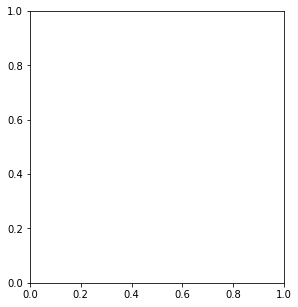

In [22]:
plt.figure(figsize = (10,5))

plt.subplot(121)
plt.plot(history['loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.subplot(122)
plt.plot(history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.tight_layout()
plt.show()

### Plots of target and output signals over time

In [ ]:
#training

y = hypermodel.predict(trainX)
mse = model.evaluate(trainX, trainY)
t=np.arange(start=0,stop=len(y), step=1)
plt.figure(figsize = (25,5))
plt.title(f'training - MSE = {np.round(mse,4)}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.4)
plt.plot(t,trainY.ravel(), color = 'r', linewidth= 0.4)

plt.figure(figsize = (25,5))
plt.title('training (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.4)
plt.plot(t[:200],trainY.ravel()[:200], color = 'r', linewidth= 0.4)

#validation

y = model.predict(validX)
mse = model.evaluate(validX, validY)
t=np.arange(start=0,stop=len(y), step=1)
plt.figure(figsize = (25,5))
plt.title(f'validation - MSE = {np.round(mse,4)}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.4)
plt.plot(t,validY.ravel(), color = 'r', linewidth= 0.4)

#test

y = model.predict(testX)
mse = model.evaluate(testX, testY)
t=np.arange(start=0,stop=len(y), step=1)
plt.figure(figsize = (25,5))
plt.title(f'test - MSE = {np.round(mse,4)}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.3)
plt.plot(t,testY.ravel(), color = 'r', linewidth= 0.3)

plt.figure(figsize = (25,5))
plt.title('test (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.5)
plt.plot(t[:200],testY.ravel()[:200], color = 'r', linewidth= 0.5)



 48/156 [========>.....................] - ETA: 0s